<a href="https://colab.research.google.com/github/mar-roige/GIS-course/blob/master/2_webmaps_and_distributions_ARCHIVED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Initial Steps

Recall from last week: if you haven't already done so: You need your own copy of this notebook. Go to "File" and 'save a copy in github' (give access if needed.... put it into the repository you made for this course).

Now you have your own copy of the notebook. Click 'open in colab' to get started working on the practical exercise.

# Interactive maps and looking more at distributions

Last week we focused on making mostly static maps, that is maps where you mostly just expect your user to look at the product you've prepared. 

This week we'll look at making maps where interactivity is part of the design. 

We'll also spend some more time on that all important topic: spatial distributions.


### Start by getting tools again.

In [0]:
#Like last time, get the tools we need at the start
import pandas as pd
import folium
import numpy as np

### And then by getting data

This week we are working with the data from the Antikythera survey project.


This data has been made available at the Archaeological Data Service (ADS) archive at https://archaeologydataservice.ac.uk/archives/view/antikythera_ahrc_2012/


It's citation is: Bevan, A. and Conolly, J. 2012. Intensive Survey Data from Antikythera, Greece. **Journal of Open Archaeology Data** 1(1), DOI: http://dx.doi.org/10.5334/4f3bcb3f7f21d.



### Open Data

Last week we mentioned open source software. Open data operates under the same broad ethos, and follows many of the same principles. Sharing, reuse, and attribution are key. If you continue to reuse the Antikythera data, be sure to continue to link back to and cite the source.

### Working with other people's data

Have a quick look around the dataset as it's described on the ADS site. You'll notice that they've split up their dataset in ways that made sense to them at the time. Specifically they've divided up the ceramics and small finds into separate files. This is a pretty normal archaeological data thing to do. 

Here's the trick. For your purposes, you want to look at both these datasets together. This means you'll have to grab both of them and combine them. This is because you are reusing the data for something new.

In [0]:
#Like last time, get the data we'll need at the start. I've been nice again and converted their coordinates to latitude and longitude for you. 
#You'll learn to do this yourself later in the course.

# we label the first dataset 'pottery'
pottery = pd.read_csv('https://raw.githubusercontent.com/ropitz/spatialarchaeology/master/data/antikythera_survey_pottery.csv')

# we label the second dataset 'small finds'
small_finds = pd.read_csv('https://raw.githubusercontent.com/ropitz/spatialarchaeology/master/data/antikythera_survey_small_finds.csv')

# then we combine the two datasets together to make a big dataset we call 'survey data'
survey_data = pd.concat([pottery,small_finds], sort=False, ignore_index=True)

Now like last week we will use the .head() function to read in the first part of the data and make sure nothing went wrong.

In [0]:
#check things loaded in and combined OK
survey_data.head()

,OID_,UID,Xsugg,Ysugg,Type_,Unit,Walker,PassGrid,Section_,SherdNo,VesselPart,PartType,VesselType,OtherType,Thickness,Coarseness,MaxSize,Feature,Comments,FabricType,MNLN,FNEB1,EB2,LPrePal,FPal,SPal,TPal,PPalPG,Geom,Arch,Class,Hell,ERom,MRom,LRom,EByz,MByz,EVen,MVen,LVen,Recent,Other,DDLat,DDLon,ORIG_OID,Pass_Grid,ObjNo,Object,Material,MN_LN,FN_EB1,FMin,PPal_PG,Geometric,Archaic,TOTAL
0,NaN,0075-7135-S-37,710076.1,3967135.2,grid,0075-7135,59,37.0,S,37.0,R,RR,JCon,Lamboglia 2,M,F,4.1,Y,"Lamboglia 2 amphora, rim. Quite fine and fairl...",Adriatic amphora fabric,0.0,0.0,0,0.0,0,0,0,0.0,0.0,0.0,0,0,0,0,100,0,0,0,0,0,0,0,35.825904,23.325570,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,0095-7135-V-1,710098.2,3967133.6,grid,0095-7135,29,37.0,V,1.0,B,U,U,U,M,C,2.4,N,NaN,GRO(b?),0.0,70.0,30,0.0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,35.825885,23.325814,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,0105-7155-S-1,710106.1,3967152.2,grid,0105-7155,28,37.0,S,1.0,Ba,BF,U,U,Tk,C,5.1,Y,Base from medium to large sized vessel,SAT,0.0,0.0,20,20.0,20,20,20,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,35.826051,23.325906,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,0115-7265-V-1,710111.3,3967265.8,grid,0115-7265,21,51.0,V,1.0,B,U,U,U,M,C,1.9,N,NaN,GRO(b?),0.0,70.0,30,0.0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,35.827073,23.325993,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,0125-7115-S-1,710111.1,3967121.2,grid,0115-7125,49,37.0,S,1.0,L?,U,CPot?,U,M,C,6.2,Y,Highly abraded small ovoid leg,MUT,0.0,0.0,10,10.0,30,30,20,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,35.825770,23.325953,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
#You can also check the individual files as well as the combined one we made
pottery.head()

,OID_,UID,Xsugg,Ysugg,Type_,Unit,Walker,PassGrid,Section_,SherdNo,VesselPart,PartType,VesselType,OtherType,Thickness,Coarseness,MaxSize,Feature,Comments,FabricType,MNLN,FNEB1,EB2,LPrePal,FPal,SPal,TPal,PPalPG,Geom,Arch,Class,Hell,ERom,MRom,LRom,EByz,MByz,EVen,MVen,LVen,Recent,Other,DDLat,DDLon,ORIG_OID
0,NaN,0075-7135-S-37,710076.1,3967135.2,grid,0075-7135,59,37,S,37,R,RR,JCon,Lamboglia 2,M,F,4.1,Y,"Lamboglia 2 amphora, rim. Quite fine and fairl...",Adriatic amphora fabric,0,0,0,0,0,0,0,0,0,0,0,0,0,0,100,0,0,0,0,0,0,0,35.825904,23.325570,1
1,NaN,0095-7135-V-1,710098.2,3967133.6,grid,0095-7135,29,37,V,1,B,U,U,U,M,C,2.4,N,NaN,GRO(b?),0,70,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35.825885,23.325814,2
2,NaN,0105-7155-S-1,710106.1,3967152.2,grid,0105-7155,28,37,S,1,Ba,BF,U,U,Tk,C,5.1,Y,Base from medium to large sized vessel,SAT,0,0,20,20,20,20,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35.826051,23.325906,3
3,NaN,0115-7265-V-1,710111.3,3967265.8,grid,0115-7265,21,51,V,1,B,U,U,U,M,C,1.9,N,NaN,GRO(b?),0,70,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35.827073,23.325993,4
4,NaN,0125-7115-S-1,710111.1,3967121.2,grid,0115-7125,49,37,S,1,L?,U,CPot?,U,M,C,6.2,Y,Highly abraded small ovoid leg,MUT,0,0,10,10,30,30,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35.825770,23.325953,5


# Now ask a question

Like we said last week, we are using maps and spatial analysis to pose, explore and respond to spatial questions. 

My question is a bit like last week's question. I want to know about how many sites are in each period, so I can try and understand changing patterns over time. 

However, you may have noticed when you read in the data that it's structure is a bit different from last week's data. Instead of each site belonging to one period, it's assinged with varying probability to several different periods. 

This is a totally legit archaeological thing to do. Many sites have activity from multiple periods, and depending on the available evidence, you might be more or less confident about the presence or absence of activity in a specific period. 

### So what do we do now?

We might start simply by assigning each site primarily to its 'most likely period'. 

This takes a few steps....

### step 1 - prepare the data


In [0]:
# first we create a subset of our data that only contains the columns with information about time
# this is in part because we want to do some operations where everything has to be a number, and some of the other fields contain text
# it's also just to make things simpler when we look at them

survey_data_time = survey_data[['MNLN', 'FNEB1',	'EB2',	'LPrePal', 'FPal', 'SPal', 'TPal', 'PPalPG', 'Geom', 'Arch', 'Class', 'Hell', 'ERom', 'MRom', 'LRom', 'EByz', 'MByz', 'EVen', 'MVen', 'LVen', 'Recent', 'Other']]
survey_data_time.head()

,MNLN,FNEB1,EB2,LPrePal,FPal,SPal,TPal,PPalPG,Geom,Arch,Class,Hell,ERom,MRom,LRom,EByz,MByz,EVen,MVen,LVen,Recent,Other
0,0.0,0.0,0,0.0,0,0,0,0.0,0.0,0.0,0,0,0,0,100,0,0,0,0,0,0,0
1,0.0,70.0,30,0.0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,20,20.0,20,20,20,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.0,70.0,30,0.0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.0,0.0,10,10.0,30,30,20,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# if you were to look through this data, you'd see some fields with null values
# null values can break number-based operations
# let's get rid of null values and make sure everything is a number
survey_data_time.astype('float64').fillna(0)


,MNLN,FNEB1,EB2,LPrePal,FPal,SPal,TPal,PPalPG,Geom,Arch,Class,Hell,ERom,MRom,LRom,EByz,MByz,EVen,MVen,LVen,Recent,Other
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,70.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,20.0,20.0,20.0,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,70.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,10.0,10.0,30.0,30.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,70.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,70.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,70.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,70.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,20.0,20.0,20.0,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### step 2 - transform the data

Data transformation is an important thing to learn to do.

Right now we have a bunch of columns with information about time. 

What we want is one single column that contains the most likely period - which is represented in each row by the column with the greatest value.

*think about that for a moment*

Right now the 'most likely period' is represented by a number in each row, but that's not the piece of information we want in our new column - we want the name of the column that contains that number.

**Data Transformation describes what we are doing here - reorganizing the data in our table**



In [0]:
#here we take the columns from all the different periods, get the one with the maximum value, and write that column's name to our new 'colmax' field
def returncolname(row, colnames):
    return colnames[np.argmax(row.values)]

survey_data_time['colmax'] = survey_data_time.apply(lambda x: returncolname(x, survey_data_time.columns), axis=1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [0]:
#we can check it has all gone well
survey_data_time.head()

,MNLN,FNEB1,EB2,LPrePal,FPal,SPal,TPal,PPalPG,Geom,Arch,Class,Hell,ERom,MRom,LRom,EByz,MByz,EVen,MVen,LVen,Recent,Other,colmax
0,0.0,0.0,0,0.0,0,0,0,0.0,0.0,0.0,0,0,0,0,100,0,0,0,0,0,0,0,LRom
1,0.0,70.0,30,0.0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,FNEB1
2,0.0,0.0,20,20.0,20,20,20,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,EB2
3,0.0,70.0,30,0.0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,FNEB1
4,0.0,0.0,10,10.0,30,30,20,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,FPal


## Merging tables

OK now we have a single column with the information we need - the most likely date. To create this column, we broke off some of our data (the columns with numbers) from the rest of the data (important descriptive text). We might well want to stick these two datasets back together before proceeding. 

**splitting and merging tables is another basic skill when working with data**




In [0]:
#now we can also add our new column back to our original data table by doing a 'merge'
#create a new table 'survey_data_maxtime' by merging our original 'survey_data' with ONLY the 'colmax' column from our new table
survey_data_maxtime = pd.merge(survey_data, survey_data_time['colmax'], how='inner', left_index=True, right_index=True)
survey_data_maxtime.head()

,OID_,UID,Xsugg,Ysugg,Type_,Unit,Walker,PassGrid,Section_,SherdNo,VesselPart,PartType,VesselType,OtherType,Thickness,Coarseness,MaxSize,Feature,Comments,FabricType,MNLN,FNEB1,EB2,LPrePal,FPal,SPal,TPal,PPalPG,Geom,Arch,Class,Hell,ERom,MRom,LRom,EByz,MByz,EVen,MVen,LVen,Recent,Other,DDLat,DDLon,ORIG_OID,Pass_Grid,ObjNo,Object,Material,MN_LN,FN_EB1,FMin,PPal_PG,Geometric,Archaic,TOTAL,colmax
0,NaN,0075-7135-S-37,710076.1,3967135.2,grid,0075-7135,59,37.0,S,37.0,R,RR,JCon,Lamboglia 2,M,F,4.1,Y,"Lamboglia 2 amphora, rim. Quite fine and fairl...",Adriatic amphora fabric,0.0,0.0,0,0.0,0,0,0,0.0,0.0,0.0,0,0,0,0,100,0,0,0,0,0,0,0,35.825904,23.325570,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LRom
1,NaN,0095-7135-V-1,710098.2,3967133.6,grid,0095-7135,29,37.0,V,1.0,B,U,U,U,M,C,2.4,N,NaN,GRO(b?),0.0,70.0,30,0.0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,35.825885,23.325814,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FNEB1
2,NaN,0105-7155-S-1,710106.1,3967152.2,grid,0105-7155,28,37.0,S,1.0,Ba,BF,U,U,Tk,C,5.1,Y,Base from medium to large sized vessel,SAT,0.0,0.0,20,20.0,20,20,20,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,35.826051,23.325906,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EB2
3,NaN,0115-7265-V-1,710111.3,3967265.8,grid,0115-7265,21,51.0,V,1.0,B,U,U,U,M,C,1.9,N,NaN,GRO(b?),0.0,70.0,30,0.0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,35.827073,23.325993,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FNEB1
4,NaN,0125-7115-S-1,710111.1,3967121.2,grid,0115-7125,49,37.0,S,1.0,L?,U,CPot?,U,M,C,6.2,Y,Highly abraded small ovoid leg,MUT,0.0,0.0,10,10.0,30,30,20,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,35.825770,23.325953,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FPal


## The curse of abbreviations

Have a look at the resulting table. What do all those column names mean? Right now you are probably justifiably confused. We'll be talking more about the mess that is 'other people's data' next week. For now, have a look at the documentation for these datasets at: https://archaeologydataservice.ac.uk/catalogue/adsdata/arch-1115-2/dissemination/csv/pottery/documentation/pottery.txt

You'll see they explain that many of those weird abbreviations are periods and that the number in each one represents the chance that a given find belongs to that period. Sometimes I wish people wouldn't use abbreviations like this, but they've defined them in their metadata file, so we can't compain too much.

## Finally, we make maps!


We're going to look at a couple different ways of making maps, because there are lots of tools we can use to do this.

### Maps for visualization and interpretation

Broadly speaking, there are two ways to approach interpreting spatial patterns. There's vislualization and interpretation, where you might visually compare distributions or densities or locations of two or more datasets by plotting them on a map and intepreting what you see. Then there's statistical analysis. 

We'll start with the tools to do the first one, and introduce statistical analysis later in the course. 

We'll also discuss the value of each approach, and when to apply it.

### As always, start with a question

As we said at the beginning of today, we're interested in change over time.

**Analysis Question:**<br>
How does the distrubution of finds change between different periods?




In [0]:
# we're going to get geopandas, another tool for making maps
!pip install geopandas


     |████████████████████████████████| 921kB 4.9MB/s 
     |████████████████████████████████| 10.1MB 23.6MB/s 
     |████████████████████████████████| 11.9MB 12.6MB/s 
  Created wheel for munch: filename=munch-2.3.2-py2.py3-none-any.whl size=6614 sha256=1cd923b69af10e446bf9e4635e6aa43f06a662037cc9d02ee782cc7707761a2c
  Stored in directory: /root/.cache/pip/wheels/db/bf/bc/06a3e1bfe0ab27d2e720ceb3cff3159398d92644c0cec2c125
Successfully built munch


In [0]:
# get some more tools for making maps (and other things)

%matplotlib inline
import geopandas as gpd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

## Geopandas

We're going to introduce a new mapping tool - geopandas. 

It can do many of the same things as folium, which we were using before.

It's particularly useful for showing categorical data. 

What's categorical data? It's anything where you have a category label, like an archaeological period. 

We could start tryping to see and understand the distributions of our sites by periods simply by mapping the period labels with different colors.


In [0]:
# take our big dataset from above and turn it from a 'dataframe' which is the data that folium uses to make maps into a 'geodataframe' which is the data geopandas uses to make maps

gdf_survey = gpd.GeoDataFrame(
    survey_data_maxtime, geometry=gpd.points_from_xy(survey_data_maxtime.DDLon, survey_data_maxtime.DDLat))
print(gdf_survey.head())

   OID_             UID     Xsugg  ...  TOTAL colmax                   geometry
0   NaN  0075-7135-S-37  710076.1  ...    NaN   LRom  POINT (23.32557 35.82590)
1   NaN   0095-7135-V-1  710098.2  ...    NaN  FNEB1  POINT (23.32581 35.82588)
2   NaN   0105-7155-S-1  710106.1  ...    NaN    EB2  POINT (23.32591 35.82605)
3   NaN   0115-7265-V-1  710111.3  ...    NaN  FNEB1  POINT (23.32599 35.82707)
4   NaN   0125-7115-S-1  710111.1  ...    NaN   FPal  POINT (23.32595 35.82577)

[5 rows x 58 columns]


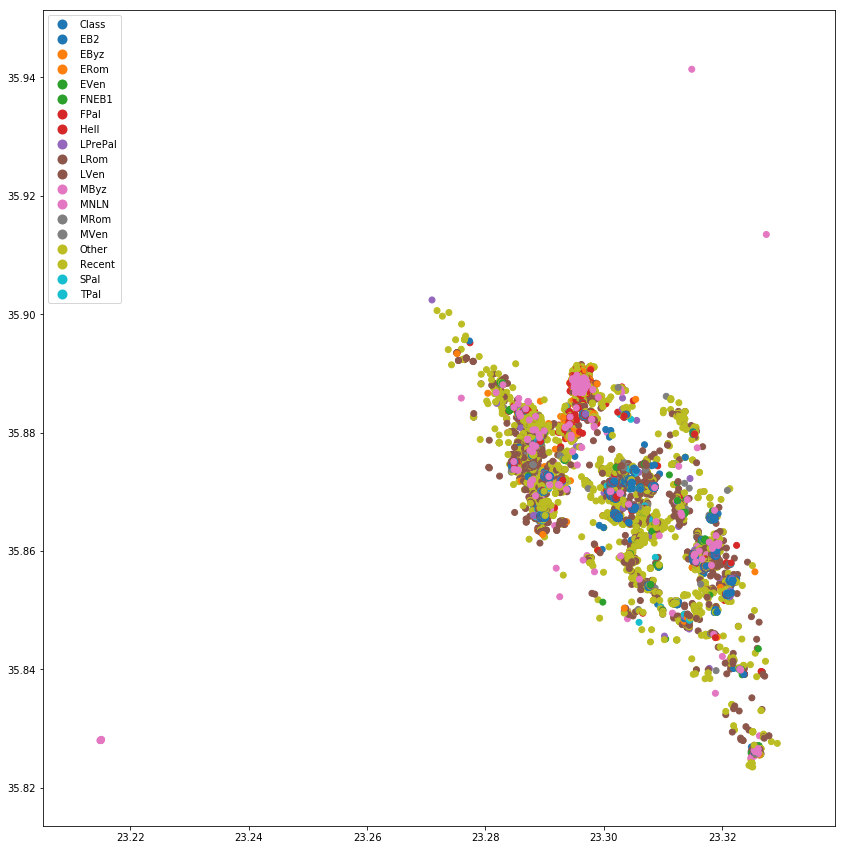

In [0]:
#plot your data colouring the points by the period to which they belong
gdf_survey.plot(column='colmax', categorical=True, legend=True, figsize=(15,15))

### Assess the resulting map

Is it useful? Why or why not?

Can you see the distribution of sites from individual periods easily?

Can you easily discern change over time?

I'm not overly convinced by the result here.

What other approach might we take?


Let's try something else


In [0]:
#Maybe it would be better to only look at two or three periods at a time

#let's select a subset of our periods to see change from the early bronze age to hellenistic to late roman

types = ['EB2','Hell','LRom']
classic = gdf_survey.loc[gdf_survey['colmax'].isin(types)]
classic.head()

,OID_,UID,Xsugg,Ysugg,Type_,Unit,Walker,PassGrid,Section_,SherdNo,VesselPart,PartType,VesselType,OtherType,Thickness,Coarseness,MaxSize,Feature,Comments,FabricType,MNLN,FNEB1,EB2,LPrePal,FPal,SPal,TPal,PPalPG,Geom,Arch,Class,Hell,ERom,MRom,LRom,EByz,MByz,EVen,MVen,LVen,Recent,Other,DDLat,DDLon,ORIG_OID,Pass_Grid,ObjNo,Object,Material,MN_LN,FN_EB1,FMin,PPal_PG,Geometric,Archaic,TOTAL,colmax,geometry
0,NaN,0075-7135-S-37,710076.1,3967135.2,grid,0075-7135,59,37.0,S,37.0,R,RR,JCon,Lamboglia 2,M,F,4.1,Y,"Lamboglia 2 amphora, rim. Quite fine and fairl...",Adriatic amphora fabric,0.0,0.0,0,0.0,0,0,0,0.0,0.0,0.0,0,0,0,0,100,0,0,0,0,0,0,0,35.825904,23.325570,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LRom,POINT (23.32557 35.82590)
2,NaN,0105-7155-S-1,710106.1,3967152.2,grid,0105-7155,28,37.0,S,1.0,Ba,BF,U,U,Tk,C,5.1,Y,Base from medium to large sized vessel,SAT,0.0,0.0,20,20.0,20,20,20,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,35.826051,23.325906,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EB2,POINT (23.32591 35.82605)
9,NaN,0125-7255-V-1,710120.9,3967251.9,grid,0125-7255,5,51.0,V,1.0,H,U,U,U,Tk,C,6.4,Y,Rounded ovoid in section. Fine sand temper wit...,OUT,0.0,0.0,20,20.0,20,20,20,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,35.826946,23.326096,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EB2,POINT (23.32610 35.82695)
12,NaN,0125-7255-V-4,710127.2,3967255.7,grid,0125-7255,5,51.0,V,4.0,B,U,U,U,M,C,2.0,N,Fine sand temper with white chert and shale in...,OUT,0.0,0.0,20,20.0,20,20,20,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,35.826979,23.326167,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EB2,POINT (23.32617 35.82698)
19,NaN,10000-60-1-65-1,706806.4,3971445.2,tract,10000,60,1.0,65,1.0,B,U,JCon,LRA 2?,M,M,5.2,Y,LRA 2? fine ridging on exterior,LRA 2 fabric,0.0,0.0,0,0.0,0,0,0,0.0,0.0,0.0,0,0,0,0,100,0,0,0,0,0,0,0,35.865427,23.290517,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LRom,POINT (23.29052 35.86543)


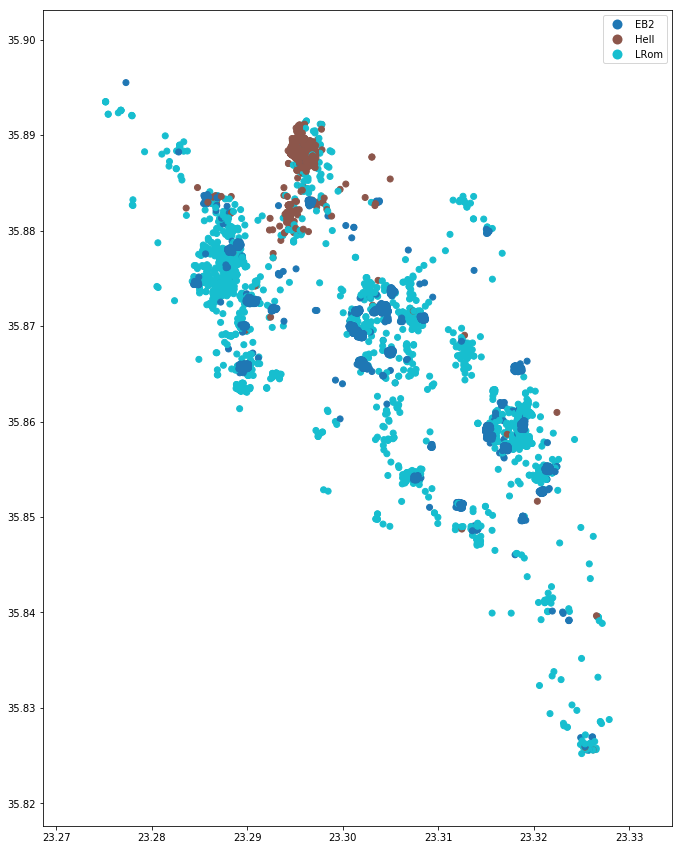

In [0]:
#plot your data colouring the points by the period to which they belong
classic.plot(column='colmax', categorical=True, legend=True, figsize=(15,15))

## Thinking about data visualization and map design

That's a bit better perhaps. The map is less crowded.

Recall our discussions about how to design a map well. Clearly too much data introduces design problems.

Well, now we can see the distributions a bit, and maybe say something about change over time, but there are still a lot of dots, and it's pretty clear dots from some periods are hidden under dots from other periods and we have no way to separate them. 

**what we need here is layers, so we can group our data and work with it interactively**
*It would also be nice to have some context for all those dots*


In [0]:
#Like last time, we'll use folium and one of it's plugins
from folium.plugins import HeatMapWithTime


### Map Visualizations with Folium


To see the survey data in context and build our interactive maps, we'll start by generating the base map that will be used throughout this notebook.

'Basemaps' are generic background maps, like a satellite image or an image of the street map. You know the different backgrounds you can show on google maps? Those are 'basemaps'. 

Have a look around the web, and you'll see that most modern online maps  use a basemap, so we're going to do so as well.


In [0]:
#get the survey area centre, like you did last week, so you can centre the map where the data is located

location_survey=survey_data_maxtime['DDLat'].mean(), survey_data_maxtime['DDLon'].mean()
print(location_survey)


(35.870086207930626, 23.301798820980512)


In [0]:
#define a basemap we can reuse. Use the coordiantes for the centre you generated just above to centre the basemap
#This is a variant on how we did things last time...

def generateBaseMap(default_location=[35.870086207930626, 23.301798820980512], default_zoom_start=11):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

### Review - basic map controls

Arguments:<br><br>
location: Define the default location to zoom at when rendering the map<br>
zoom_start: The zoom level that the map will default to when rendering the map<br>
control_scale: Shows the map scale for a given zoom level

In [0]:
#check the basemap is working
base_map = generateBaseMap()
base_map

In [0]:
#lets get the heatmap tool, like last time, let's also get a measure control so we can measure distance
from folium import plugins
from folium.plugins import HeatMap
from folium.plugins import MeasureControl

Let's start by comparing MRom to LRom, that is middle roman to late roman sites by putting their data in separate layers.

In [0]:
# make a layer for when each period is more than 50% likely, so you have all the sites that are probably in that period
survey_data_MRom = survey_data_maxtime.loc[(survey_data_maxtime['MRom'] > 50)]
survey_data_ERom = survey_data_maxtime.loc[(survey_data_maxtime['ERom'] > 50)]


### The concept of layers

We've introduced a new concept here. Maps have 'layers'. Each layer contains information and can be turned on and off. Think of this like a stack of transparent paper. Each sheet of paper is a layer, and can be added to or taken away from the stack. Their order can also be changed.

In [0]:
# like last time, make heatmaps, but one for each period,  put them in different layers.
base_map = generateBaseMap()
mrom = HeatMap(data=survey_data_MRom[['DDLat', 'DDLon', 'MRom']].groupby(['DDLat', 'DDLon']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)
erom = HeatMap(data=survey_data_ERom[['DDLat', 'DDLon', 'ERom']].groupby(['DDLat', 'DDLon']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)

#give the layers sensible names
mrom.layer_name = 'Middle Roman Distribution'
erom.layer_name = 'Early Roman Distribution'

# add the layer control. This is the tool that lets you turn different layers in your map on and off
folium.LayerControl().add_to(base_map)


In [0]:
#Now generate your map by calling it by its name
base_map

Now try and add some more layers to the map to show other periods!

In [0]:
# make a layer for when the max period is LRom or MRom to compare these periods
survey_data_lrommax = survey_data_maxtime.loc[(survey_data_maxtime['colmax'] =='LRom')]
survey_data_mrommax = survey_data_maxtime.loc[(survey_data_maxtime['colmax'] =='MRom')]


In [0]:

# like last time, make heatmaps, but one for each period,  put them in different layers
base_map = generateBaseMap()

lrommax = HeatMap(data=survey_data_lrommax[['DDLat', 'DDLon']].groupby(['DDLat', 'DDLon']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)
mrommax = HeatMap(data=survey_data_mrommax[['DDLat', 'DDLon']].groupby(['DDLat', 'DDLon']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)

#give the layers sensible names
lrommax.layer_name = 'Late Roman Distribution'
mrommax.layer_name = 'Middle Roman Distribution'

# add the layer control
folium.LayerControl().add_to(base_map)
base_map


# Adds a measure tool to the top right

base_map.add_child(MeasureControl())


# Making visual comparisons

Perhaps it will be more useful to be able to view our distributions and explore them side by side, to help us compare what is happening in these two periods.

In [0]:
# get another plugin for side by side maps
from folium.plugins import DualMap

In [0]:
# declare you are making a new map "m"

# set the location to the location of your survey, set your starting zoom
m = plugins.DualMap(location=location_survey, tiles=None, zoom_start=13)

# the dual maps plugin automatically defines two buddy maps, "m1" and "m2" which pan and zoom together

# give yourself some options in life for your base layers, add them to both maps 'm1' and 'm2' by just using "m"
folium.TileLayer('cartodbpositron').add_to(m)
folium.TileLayer('openstreetmap').add_to(m)


# like last time, make heatmaps, one for each period,  put them in different layers
# put one layer in the left hand map 'm' and the other in the right hand map 'm2'

lrommax = HeatMap(data=survey_data_lrommax[['DDLat', 'DDLon']].groupby(['DDLat', 'DDLon']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(m.m1)
mrommax = HeatMap(data=survey_data_mrommax[['DDLat', 'DDLon']].groupby(['DDLat', 'DDLon']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(m.m2)

#give the layers sensible names
lrommax.layer_name = 'Late Roman Distribution'
mrommax.layer_name = 'Middle Roman Distribution'

# layer control time
folium.LayerControl(collapsed=False).add_to(m)

# Adds a measure tool to the top right

m.add_child(MeasureControl())

#draw your side by side maps

m

## visualization and interpretation

Thought exercise: The results of these two maps should be similar but slightly different. What is making the difference?

How good are you at interpreting these distributions and comparing them visually?

*This is me hinting at you that you are going to end up wanting to use statistics eventually*


 

# Think about basic principles

The principles of what we've done this week are the same as the principles of what we did last week. 

I think it's important to learn to do things more than one way, and to adapt to slightly different tools. The software and code packages used for modern spatial analysis and mapping are pretty diverse and are always developing as people improve things. It doesn't make much sense to just learn one way of making maps mechanistically. The important thing is to understand the principles of what you're doing. 

In any code package that is meant to be used for making maps, odds are good you will find a way to set the zoom level, set the centre starting location, and set the initial scale. 

You will be able to set up colour schemes, map attributes, and make layers. Knowing keywords and princples is the important thing. 

## The End

That's all for today. Be sure to save your copy of the notebook in your own repo so I can see it!